In [1]:
ENV = 'Kaggle' # VAST, Kaggle

In [2]:
import pandas as pd
import numpy as np
import os

import ast

import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):

from tqdm import tqdm

import gc


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools


# load image with Pillow
from PIL import Image

from numpy import asarray

from skimage.transform import resize


import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)

print(torchvision.__version__)

1.11.0
0.12.0


In [3]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [4]:
if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

Num GPUs: 1
GPU Type: Tesla P100-PCIE-16GB


In [5]:
IMAGES_FOLDER = 'images'

if ENV == 'VAST':
    
    root = '/root'
    base_path = '/root/global-wheat-head-dataset-2021/gwhd_2021/'
    data_path = '/root/exp_05_df_rows_w_folds.csv'
    images_path = '/root/global-wheat-head-dataset-2021/gwhd_2021/images/'
    

if ENV == 'Kaggle':
    
    root = '/kaggle/working'
    base_path = '../input/global-wheat-head-dataset-2021/gwhd_2021/'
    data_path = '../input/exp05-gwhd-2-prepare-the-data/df_rows_w_folds.csv'
    images_path = '../input/global-wheat-head-dataset-2021/gwhd_2021/images/'
    
print(ENV)

Kaggle


In [6]:
os.listdir('/kaggle/input/smartwheat-data/')

['exp05_df_rows_w_folds.csv', 'exp7_best.pt', 'df_rows.csv', 'exp03_best.pt']

## Config

In [7]:
# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0


# I'm adding a target called 'nothing' because Yolo does not predict a class 
# for images on which it didn't detect anything. This just helps make the analysis
# of the results easier.
CLASS_LIST = ['nothing', 'wheat_head']
LABEL_LIST = [0,1]


IMG_EXT = '.png' # .jpg, .png --> include the dot

# Yolo setup:
NUM_EPOCHS = 3 #100

# The batch size must be a even number when using multiple GPUs
BATCH_SIZE = 24 #110
IMAGE_SIZE = 512 # Yolo will automatically resize the input images to this size.

NUM_CORES = os.cpu_count()
NUM_CORES

2

## Set up Yolov5 - For offline use

The Yolov5 model being used here needs to have the internet turned for training to work. However, it does not need to have the internet on during inference.

In [8]:
# Copy the yolov5 folder from the notebook to  /kaggle/working/
# The folder will be renamed yolov5 when copied.
# The yolov5-v5.0 folder also contains the trained weights.


if os.path.isdir(f'{root}/yolov5') == False:
    
    if ENV == 'Kaggle':
        shutil.copytree('../input/my-yolov5-for-offline-use/yolov5-v5.0', '/kaggle/working/yolov5')
        
    if ENV == 'VAST':
        shutil.copytree('my-yolov5-for-offline-use/yolov5-v5.0', f'{root}/yolov5')

In [9]:
!ls

__notebook__.ipynb  yolov5


## Load the data

In [10]:
path = data_path

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(275496, 9)


image_id        BoxesString  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     99 692 160 764   
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     641 27 697 115   
2  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...  935 978 1012 1020   
3  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    377 834 463 890   
4  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    654 797 696 837   

      domain  target  height  width source  \
0  Arvalis_1       1    1024   1024  train   
1  Arvalis_1       1    1024   1024  train   
2  Arvalis_1       1    1024   1024  train   
3  Arvalis_1       1    1024   1024  train   
4  Arvalis_1       1    1024   1024  train   

                                                path  fold  
0  ../input/global-wheat-head-dataset-2021/gwhd_2...   3.0  
1  ../input/global-wheat-head-dataset-2021/gwhd_2...   3.0  
2  ../input/global-wheat-head-dataset-2021/gwhd_2...   3.0  
3  ../input/global-wheat-head-dataset-2021/gwhd_2...   3.0  
4  ../input/global-wheat-head-dataset-2021/gwhd_2...   3.0

## Create a column for the bbox info

In [11]:
# Put the bbox info for each image into a list of bbox dicts
# This code assumes one bbox per row in df_data.


bbox_list = []

for i in tqdm(range(0, len(df_data)), total=len(df_data)):
    
    target = df_data.loc[i, 'target']
    box_str = df_data.loc[i, 'BoxesString']
    
    # Split in to list using the space
    coords_list = box_str.split(' ')
    
    if target != 0:
    
        xmin = ast.literal_eval(coords_list[0])
        ymin = ast.literal_eval(coords_list[1])
        xmax = ast.literal_eval(coords_list[2])
        ymax = ast.literal_eval(coords_list[3])
        
        #x = round(xmin)
        #y = round(ymin)
        width = round(xmax - xmin)
        height = round(ymax - ymin)

        bbox_dict ={
            'x': xmin,
            'y': ymin,
            'width': width,
            'height': height
        }

        bbox_list.append(bbox_dict)
        
    else:
        bbox_list.append('none')
        
        
# Add the bbox_list to df_data
df_data['boxes'] = bbox_list

#print(df_data.shape)

#df_data.head()

100%|██████████| 275496/275496 [00:10<00:00, 25148.93it/s]


## Create the train and val sets

In [12]:
# How to choose the fold to train on.

fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print('Train')
print(len(df_train))
print(df_train['target'].value_counts())
print('')
print('Val')
print(len(df_val))
print(df_val['target'].value_counts())


Train
236311
1    236204
0       107
Name: target, dtype: int64

Val
39185
1    39167
0       18
Name: target, dtype: int64


## Helper functions

In [13]:

# Draw the square dots on the image
def draw_square_dot(image, xmin, ymin, xmax, ymax, dot_width, text=None, line_thickness=20):
    """
    Set text=None to only draw a bbox without
    any text or text background.
    E.g. set text='Balloon' to write a
    title above the bbox.

    Output:
    Returns an image with one dot drawn at the bbox center.
    The title is optional.
    To draw a second bounding box pass the output image
    into this function again.

    """

    w = xmax - xmin
    h = ymax - ymin


    x_cent = round(xmin + w/2)
    y_cent = round(ymin + h/2)
    x1 = x_cent - dot_width
    y1 = y_cent - dot_width
    x2 = x_cent + dot_width
    y2 = y_cent + dot_width

    # Draw the bounding box
    # ......................

    start_point = (x1, y1)
    end_point = (x2, y2)
    bbox_color = (255, 255, 255) # white
    bbox_thickness = line_thickness

    # Draw a filled square
    # -1 will fill the rectangle
    image = cv2.rectangle(image, start_point, end_point, bbox_color, -1)

    # Draw a border around the filled square in a different colour
    bbox_color = (255, 0, 255) # blue border
    image = cv2.rectangle(image, start_point, end_point, bbox_color, bbox_thickness)


    # Draw the background behind the text
    # ....................................

    # Only do this if text is not None.
    if text:
        # Draw the background behind the text
        #text_bground_color = (0, 0, 0)  # black
        #cv2.rectangle(image, (xmin, ymin - 150), (xmin + w, ymin), text_bground_color, -1)

        # Draw the text
        text_color = (255, 255, 255)  # white
        font = cv2.FONT_HERSHEY_DUPLEX
        origin = (xmin, ymin - 30)
        fontScale = 3
        thickness = 10

        image = cv2.putText(image, text, origin, font,
                            fontScale, text_color, thickness, cv2.LINE_AA)

    return image

In [14]:
def draw_dots_on_detected_heads(image1, image_id):   
    
    df2 = df_preds[df_preds['image_id'] == image_id]

    df2 = df2.reset_index(drop=True)

    orig_image_h = 1024
    orig_image_w = 1024


    for j in range(0, len(df2)):

        w = int(df2.loc[j,'bbox_width'] * orig_image_w)
        h = int(df2.loc[j,'bbox_height'] * orig_image_h)

        x_cent = orig_image_w * df2.loc[j,'x-center']
        y_cent = orig_image_h * df2.loc[j,'y-center']

        xmin = int(x_cent - (w / 2))
        ymin = int(y_cent - (h / 2))

        xmax = xmin + w
        ymax = ymin + h

        # Draw the bbox on the image
        start_point = (xmin, ymin) 
        end_point = (xmax, ymax) 
        bbox_color = (255, 255, 255) # white
        bbox_thickness = 5

        #image1 = cv2.rectangle(image1, start_point, end_point, bbox_color, bbox_thickness)
        dot_width = 10
        image1 = draw_square_dot(image1, xmin, ymin, xmax, ymax, dot_width, text=None, line_thickness=bbox_thickness)
        
    return image1

In [15]:
# Draw a dot at the center of each ground truth bounding box

def draw_dots_on_ground_truth_heads(image, image_id):

    df1 = df_val[df_val['image_id'] == image_id]

    df1 = df1.reset_index(drop=True)

    box_list = list(df1[ 'boxes'])

    print(len(box_list))

    for coords_dict in box_list:

        #coords_dict = ast.literal_eval(coords_dict)

        xmin = coords_dict['x']
        ymin = coords_dict['y']
        height = coords_dict['height']
        width = coords_dict['width']

        xmax = xmin + width
        ymax = ymin + height

        # Draw the bbox on the image
        start_point = (xmin, ymin) 
        end_point = (xmax, ymax) 
        bbox_color = (255, 255, 0) 
        bbox_thickness = 5

        #image = cv2.rectangle(image, start_point, end_point, bbox_color, bbox_thickness)
        dot_width = 10
        image = draw_square_dot(image, xmin, ymin, xmax, ymax, dot_width, text=None, line_thickness=bbox_thickness)

    return image



In [16]:
# Draw two images side by side

def show_true_and_pred_images(image_id):

    # Image 1
    # --------

    # Load the image
    path = base_path + 'images/' + image_id +'.png'
    image = cv2.imread(path)

    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    # Display a large image
    plt.figure(figsize=(20,20))

    # Our subplot will contain 2 row and 2 columns
    # plt.subplot(nrows, ncols, plot_number)
    plt.subplot(2, 2, 1)

    image1 = draw_dots_on_ground_truth_heads(image, image_id)

    i = 1
    plt.subplot(1,2,i)

    plt.imshow(image1)
    plt.tight_layout()
    plt.title('true wheat heads', fontsize=30)
    plt.axis('off')


    # Image 2
    # ---------

    # Load the image
    path = base_path + 'images/' + image_id +'.png'
    image = cv2.imread(path)

    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    i = 2
    plt.subplot(1,2,i)

    image2 = draw_dots_on_detected_heads(image, image_id)

    plt.imshow(image2)
    plt.tight_layout()
    plt.title('detected wheat heads', fontsize=30)
    plt.axis('off')

    plt.show()

## Make a prediction on the val set

In [17]:
# change the working directory
os.chdir(root)

!pwd

/kaggle/working


In [18]:
# Create a folder to store the extracted files
if os.path.isdir('yolo_images_dir') == False:
    yolo_images_dir = 'yolo_images_dir'
    os.mkdir(yolo_images_dir)
    
    
    
val_fname_list = list(df_val['image_id'])

for image_id in tqdm(val_fname_list, total=len(val_fname_list)):
    
    fname = str(image_id) + IMG_EXT
    
    # Copy the image to images
    # Set the path to the images here.
    shutil.copyfile(
        f"{images_path}/{fname}",
        f"yolo_images_dir/{fname}")
    
    
len(os.listdir('yolo_images_dir'))

100%|██████████| 39185/39185 [04:49<00:00, 135.57it/s]


931

In [19]:
# change the working directory
os.chdir(f'{root}/yolov5')

!pwd

/kaggle/working/yolov5


In [20]:
# Make a prediction on all images in images_dir

# The model only creates a txt file if it finds objects on an image.

test_images_path = f'{root}/yolo_images_dir'
yolo_model_path = '/kaggle/input/smartwheat-data/exp7_best.pt'

# Ensembling two Yolo models
# How to ensemble Yolov5 models:
# Ref: https://github.com/ultralytics/yolov5/issues/318

!python detect.py --source $test_images_path --weights $yolo_model_path --img $IMAGE_SIZE --save-txt --save-conf --exist-ok


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=512, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/working/yolo_images_dir', update=False, view_img=False, weights=['/kaggle/input/smartwheat-data/exp7_best.pt'])
Fusing layers... 
/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/931 /kaggle/working/yolo_images_dir/00f09bc4483ab2f654ff0f6a3236442597dd67595320fa6c3984a9ab8c844c6d.png: 512x512 56 1s, Done. (0.045s)
image 2/931 /kaggle/working/yolo_images_dir/01351c964abba54bedbb7ef4e3777a30c9683388b5dce987a91d8944722a9232.png: 512x512 51 1s, Done. (0.030s)
image 3/931 /kaggle/wo

## Process the predictions

In [21]:
txt_files_list = os.listdir('runs/detect/exp/labels')

print(len(txt_files_list))
print(txt_files_list[0])

913
981494153750db3606dde8f365457cb47139f7e8394abc28007a27743b89120e.txt


In [22]:
# Display the contents of the text file

# Note: Every time you run predict it appends the preds to the same txt file.
! cat 'runs/detect/exp/c585e49e4edba923f83af18f13b4f7cf2392cea4050c25262e8133f753ded3e3.txt'

cat: runs/detect/exp/c585e49e4edba923f83af18f13b4f7cf2392cea4050c25262e8133f753ded3e3.txt: No such file or directory


In [23]:
# Put the info inside all the txt files into one dataframe.
# Remember that if the image does not have any bounding boxes
# then Yolo does not create a txt file for it.

txt_files_list = os.listdir('runs/detect/exp/labels')

for i, txt_file in enumerate(txt_files_list):
    
    # set the path
    path = f'runs/detect/exp/labels/{txt_file}'
    
    # create a list of column names
    cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']

    # put the file contents into a dataframe
    df = pd.read_csv(path, sep=" ", header=None)
    
    # add the column names to the datafrae
    df.columns = cols
    
    # Split the txt fname on the full stop and choose the first item 
    # in the list. The add the .jpg extension.
    # 87a0829f53c1.txt becomes 87a0829f53c1_image
    #fname = txt_file.split('.')[0] + '.png'
    fname = txt_file.replace(".txt", IMG_EXT)
    
    # add a new column with the fname
    df['id'] = fname
 
    # stack the dataframes for each txt file
    if i == 0:
        
        df_test_preds = df
    else:
        
        df_test_preds = pd.concat([df_test_preds, df], axis=0)
       
    
    
print(len(txt_files_list))
print(df_test_preds['id'].nunique())
print(df_test_preds.shape)

# Change the name of the dataframe
df_preds = df_test_preds.copy()

df_preds.head()

913
913
(39508, 7)


class  x-center  y-center  bbox_width  bbox_height  conf-score  \
0      1  0.042969  0.846680    0.060547     0.072266    0.270020   
1      1  0.990234  0.054199    0.019531     0.069336    0.294434   
2      1  0.364258  0.823242    0.042969     0.041016    0.400146   
3      1  0.386719  0.756836    0.058594     0.052734    0.410645   
4      1  0.819336  0.655273    0.064453     0.052734    0.423584   

                                                  id  
0  981494153750db3606dde8f365457cb47139f7e8394abc...  
1  981494153750db3606dde8f365457cb47139f7e8394abc...  
2  981494153750db3606dde8f365457cb47139f7e8394abc...  
3  981494153750db3606dde8f365457cb47139f7e8394abc...  
4  981494153750db3606dde8f365457cb47139f7e8394abc...

## Review the preds

In [24]:
# Create an image_id column

def get_image_id(x):
    
    image_id = x.split('.')[0]
    
    return image_id

df_preds['image_id'] = df_preds['id'].apply(get_image_id)

df_preds.head()

class  x-center  y-center  bbox_width  bbox_height  conf-score  \
0      1  0.042969  0.846680    0.060547     0.072266    0.270020   
1      1  0.990234  0.054199    0.019531     0.069336    0.294434   
2      1  0.364258  0.823242    0.042969     0.041016    0.400146   
3      1  0.386719  0.756836    0.058594     0.052734    0.410645   
4      1  0.819336  0.655273    0.064453     0.052734    0.423584   

                                                  id  \
0  981494153750db3606dde8f365457cb47139f7e8394abc...   
1  981494153750db3606dde8f365457cb47139f7e8394abc...   
2  981494153750db3606dde8f365457cb47139f7e8394abc...   
3  981494153750db3606dde8f365457cb47139f7e8394abc...   
4  981494153750db3606dde8f365457cb47139f7e8394abc...   

                                            image_id  
0  981494153750db3606dde8f365457cb47139f7e8394abc...  
1  981494153750db3606dde8f365457cb47139f7e8394abc...  
2  981494153750db3606dde8f365457cb47139f7e8394abc...  
3  981494153750db3606dde8f365457cb47139f7e8394abc...  
4  981494153750db3606dde8f365457cb47139f7e8394abc...

## Get the num true heads on each image

In [25]:
def get_num_bboxes(x):
    
    if x == 'no_box':
        return 0
    
    else:
    
        # Create a list of bbox coords.
        # Each list item is a string
        box_list = x.split(';')

        num_bboxes = len(box_list)

        return num_bboxes

df_val['num_bboxes'] = df_val['BoxesString'].apply(get_num_bboxes)

#df_val.head()

In [26]:
val_image_id_list = list(df_val['image_id'].unique())

num_list = []
domain_list = []

for image_id in val_image_id_list:
    
    df = df_val[df_val['image_id'] == image_id]
    df = df.reset_index(drop=True)
    
    num_boxes = df['num_bboxes'].sum()
    domain = df.loc[0, 'domain']
    
    num_list.append(num_boxes)
    domain_list.append(domain)

## Create df_boxes

In [27]:
info_dict = {
    'image_id': val_image_id_list,
    'domain': domain_list,
    'num_true_boxes': num_list
}

df_boxes = pd.DataFrame(info_dict)

df_boxes.head()

image_id     domain  \
0  be1652110a44acd24b42784356e965ce84a04893c3f1bb...  Arvalis_1   
1  68b0c06932935f8df33a351174e1e3ab0d6f058b64e4f9...  Arvalis_1   
2  5fd9a56aa2620ccc0ef158d66cd5065c0c41b7dc897ff8...  Arvalis_1   
3  bacd773ca3950074b36218aa5f1c477101a17ee83bb96c...  Arvalis_1   
4  12421504268e0c36e905ea12119c44d3c3f19cbc2270ab...  Arvalis_1   

   num_true_boxes  
0              43  
1              50  
2              52  
3              46  
4              50

## Add a column for the Development stage

In [28]:
!pwd

/kaggle/working/yolov5


In [29]:
# change the working directory
os.chdir(root)

!pwd

/kaggle/working


In [30]:
# Load the metadata

path = base_path + 'metadata_dataset.csv'
df_meta = pd.read_csv(path, sep=';')

print(df_meta.shape)

df_meta.head()

(47, 4)


name      country    location   development_stage
0          Ethz_1  Switzerland       Usask             Filling
1          Rres_1           UK  Rothamsted  Filling - Ripening
2  ULiège-GxABT_1      Belgium    Gembloux            Ripening
3          NMBU_1       Norway        NMBU             Filling
4          NMBU_2       Norway        NMBU            Ripening

In [31]:
# Convert the domain/name to lowercase e.g. Ethz_1 does not match ETHZ_1

def convert_to_lowercase(x):
    
    lower_str = x.lower()
    
    return lower_str


df_meta['name'] = df_meta['name'].apply(convert_to_lowercase)

df_boxes['domain'] = df_boxes['domain'].apply(convert_to_lowercase)

In [32]:
df_meta = df_meta.set_index('name')

dev_stage_list = []

for i in range(0, len(df_boxes)):
    
    domain = df_boxes.loc[i, 'domain']
    
    dev_stage = df_meta.loc[domain, 'development_stage']
    
    dev_stage_list.append(dev_stage)
    

df_boxes['dev_stage'] = dev_stage_list

df_boxes.head()

image_id     domain  \
0  be1652110a44acd24b42784356e965ce84a04893c3f1bb...  arvalis_1   
1  68b0c06932935f8df33a351174e1e3ab0d6f058b64e4f9...  arvalis_1   
2  5fd9a56aa2620ccc0ef158d66cd5065c0c41b7dc897ff8...  arvalis_1   
3  bacd773ca3950074b36218aa5f1c477101a17ee83bb96c...  arvalis_1   
4  12421504268e0c36e905ea12119c44d3c3f19cbc2270ab...  arvalis_1   

   num_true_boxes       dev_stage  
0              43  Post-flowering  
1              50  Post-flowering  
2              52  Post-flowering  
3              46  Post-flowering  
4              50  Post-flowering

In [33]:
df_boxes['dev_stage'].value_counts()

Filling               346
Filling - Ripening    256
Ripening              200
Post-flowering        102
multiple               19
Post-Flowering          8
Name: dev_stage, dtype: int64

## Add pred data to df_boxes

In [34]:
pred_image_id_list = list(df_preds['image_id'].unique())

num_list = []

for image_id in val_image_id_list:
    
    if image_id in pred_image_id_list:
        
        df = df_preds[df_preds['image_id'] == image_id]
        num_boxes = len(df)
        
        num_list.append(num_boxes)
        
    else:
        
        num_list.append(0)

In [35]:
df_boxes['num_pred_boxes'] = num_list

df_boxes.head()

image_id     domain  \
0  be1652110a44acd24b42784356e965ce84a04893c3f1bb...  arvalis_1   
1  68b0c06932935f8df33a351174e1e3ab0d6f058b64e4f9...  arvalis_1   
2  5fd9a56aa2620ccc0ef158d66cd5065c0c41b7dc897ff8...  arvalis_1   
3  bacd773ca3950074b36218aa5f1c477101a17ee83bb96c...  arvalis_1   
4  12421504268e0c36e905ea12119c44d3c3f19cbc2270ab...  arvalis_1   

   num_true_boxes       dev_stage  num_pred_boxes  
0              43  Post-flowering              49  
1              50  Post-flowering              51  
2              52  Post-flowering              53  
3              46  Post-flowering              48  
4              50  Post-flowering              50

## Analyze df_boxes

In [36]:
df_boxes['diff'] = abs(df_boxes['num_true_boxes'] - df_boxes['num_pred_boxes'])
df_boxes['count_error'] = df_boxes['diff']/df_boxes['num_true_boxes']

# Remove the rows with no true boxes
df = df_boxes[df_boxes['num_true_boxes'] != 0]

#df.head()

## Get the mean percentage difference

In [37]:
df['count_error'].mean()

0.09097777756317034

## Group by domain

In [38]:
# Group and take the mean
df_domains = df.groupby('domain').mean()

# Only show certain columns
cols = ['diff', 'count_error']
df_domains = df_domains[cols]

df_domains['count_error'] = df_domains['count_error']

# Sort by percentage diff
df_domains = df_domains.sort_values(by=['count_error'])

In [39]:
domain_list = list(df_domains.index)

dev_list = []
country_list = []
location_list = []

for domain in domain_list:
    
    dev_stage = df_meta.loc[domain, 'development_stage']
    country = df_meta.loc[domain, 'country']
    location = df_meta.loc[domain, 'location']
    
    dev_list.append(dev_stage)
    country_list.append(country)
    location_list.append(location)
    
    
df_domains['dev_stage'] = dev_list
df_domains['country'] = country_list
df_domains['location'] = location_list

# Rename the diff column with a name that's easier to understand
df_domains['num_heads_diff'] = list(df_domains['diff'])

# Remove the diff column
df_domains = df_domains.drop('diff', axis=1)

# Change the column order
new_cols = ['count_error', 'dev_stage', 'country', 'location']
df_domains = df_domains[new_cols]

# Save as a csv file
path = 'df_domains.csv'
df_domains.to_csv(path, index=False)

df_domains.head(50)

count_error           dev_stage      country        location
domain                                                                      
nau_2              0.023612      Post-flowering        China           Baima
arvalis_7          0.029724  Filling - Ripening       France             VLB
arvalis_6          0.040967  Filling - Ripening       France             VSC
cimmyt_2           0.046428      Post-flowering       Mexico  Ciudad Obregon
arvalis_9          0.050163            Ripening       France             VLB
ksu_2              0.050217      Post-flowering           US             KSU
nmbu_1             0.051681             Filling       Norway            NMBU
uq_7               0.053276            Ripening    Australia          Gatton
arvalis_10         0.054295             Filling       France            Mons
utokyo_2           0.055836            Ripening        Japan    NARO-Tsukuba
arvalis_8          0.056361  Filling - Ripening       France             VLB
usask_1            0.056892  Filling - Ripening       Canada    Saskatchewan
inrae_1            0.057243  Filling - Ripening       France        Toulouse
nau_3              0.063310             Filling        China           Baima
ethz_1             0.065629             Filling  Switzerland           Usask
uq_4               0.066150             Filling    Australia          Gatton
cimmyt_3           0.068078      Post-flowering       Mexico  Ciudad Obregon
utokyo_1           0.073192            Ripening        Japan    NARO-Tsukuba
arvalis_3          0.074205  Filling - Ripening       France          Gréoux
uq_5               0.074743  Filling - Ripening    Australia          Gatton
arvalis_2          0.079165             Filling       France          Gréoux
ksu_3              0.079598             Filling           US             KSU
nmbu_2             0.079973            Ripening       Norway            NMBU
ksu_1              0.080532      Post-flowering           US             KSU
cimmyt_1           0.083744      Post-flowering       Mexico  Ciudad Obregon
nau_1              0.085662      Post-flowering        China           Baima
arvalis_1          0.086056      Post-flowering       France          Gréoux
uq_6               0.087129  Filling - Ripening    Australia          Gatton
rres_1             0.092703  Filling - Ripening           UK      Rothamsted
ksu_4              0.094368            Ripening           US             KSU
arvalis_12         0.097382             Filling       France          Gréoux
arvalis_4          0.097825             Filling       France          Gréoux
uliège-gxabt_1     0.103235            Ripening      Belgium        Gembloux
uq_2               0.111111      Post-flowering    Australia          Gatton
utokyo_3           0.120564            multiple        Japan   NARO-Hokkaido
arc_1              0.126821             Filling        Sudan      Wad Medani
arvalis_5          0.129560             Filling       France             VLB
uq_10              0.137512  Filling - Ripening    Australia          Gatton
uq_3               0.142857             Filling    Australia          Gatton
ukyoto_1           0.144977      Post-Flowering        Japan           Kyoto
arvalis_11         0.186856             Filling       France             VLB
uq_8               0.199079            Ripening    Australia      McAllister
uq_9               0.207946  Filling - Ripening    Australia      Brookstead
uq_1               0.216057      Post-flowering    Australia          Gatton
uq_11              0.241809      Post-flowering    Australia          Gatton
terraref_1         0.283192            Ripening           US     Maricopa,AZ
terraref_2         0.383447             Filling           US     Maricopa,AZ

## Group by dev_stage

In [40]:
def convert_to_lower_case(x):
    
    return(x.lower())


df_domains['dev_stage'] = df_domains['dev_stage'].apply(convert_to_lower_case)

In [41]:
df_domains['dev_stage'].value_counts()

filling               14
post-flowering        12
filling - ripening    11
ripening               9
multiple               1
Name: dev_stage, dtype: int64

In [42]:
# Group and take the mean
df_dev = df_domains.groupby('dev_stage').mean()

# Sort by percentage diff
df_dev = df_dev.sort_values(by=['count_error'])


# Save as a csv file
path = 'df_dev.csv'
df_dev.to_csv(path, index=False)

df_dev.head()

count_error
dev_stage                      
filling - ripening     0.083220
post-flowering         0.103190
ripening               0.110257
filling                0.116041
multiple               0.120564

## Sort all preds by count_error

In [43]:
# Sort by count_error
df_sorted = df.sort_values(by=['count_error'])

df_sorted = df_sorted.reset_index(drop=True)

df_sorted.head()

image_id    domain  \
0  a032b7c71dd8764dc7cfa87f4781c7921395934f76e2f2...  utokyo_1   
1  42014da2dc3bf690d1b52e0a15f26131267081f4d96221...  utokyo_1   
2  20d1649beb0899588bc565886f2d403672f5f190ce57d9...  ukyoto_1   
3  35796aa30b650c86d1dd2d25d236f45721b995ab37c36c...  utokyo_1   
4  a30582eb817c2b32bade889008c7ea5f585dc3e23c933c...   inrae_1   

   num_true_boxes           dev_stage  num_pred_boxes  diff  count_error  
0              28            Ripening              28     0          0.0  
1              19            Ripening              19     0          0.0  
2               6      Post-Flowering               6     0          0.0  
3              26            Ripening              26     0          0.0  
4              13  Filling - Ripening              13     0          0.0

In [44]:
df_sorted.tail()

image_id      domain  \
908  a26431764aa26663126b5b70e862d3adcfc15b364df9c2...  terraref_2   
909  c82496582a9a410fc87e3ed766dc03135a867ee041b3ed...  terraref_1   
910  85fc18aa3f405296db7abbb320ea5653d6855fb2533e10...  terraref_1   
911  894bab6a5148f0e9d98105ca69a3634dccad462422f8df...   arvalis_5   
912  7cf68949aa01efc6dce1c58247f550d986fec20c15d947...  terraref_2   

     num_true_boxes dev_stage  num_pred_boxes  diff  count_error  
908               6   Filling               1     5     0.833333  
909               1  Ripening               0     1     1.000000  
910               1  Ripening               0     1     1.000000  
911               1   Filling               0     1     1.000000  
912               3   Filling               0     3     1.000000

## Display three good results

Each dot is the center of a bounding box.

14


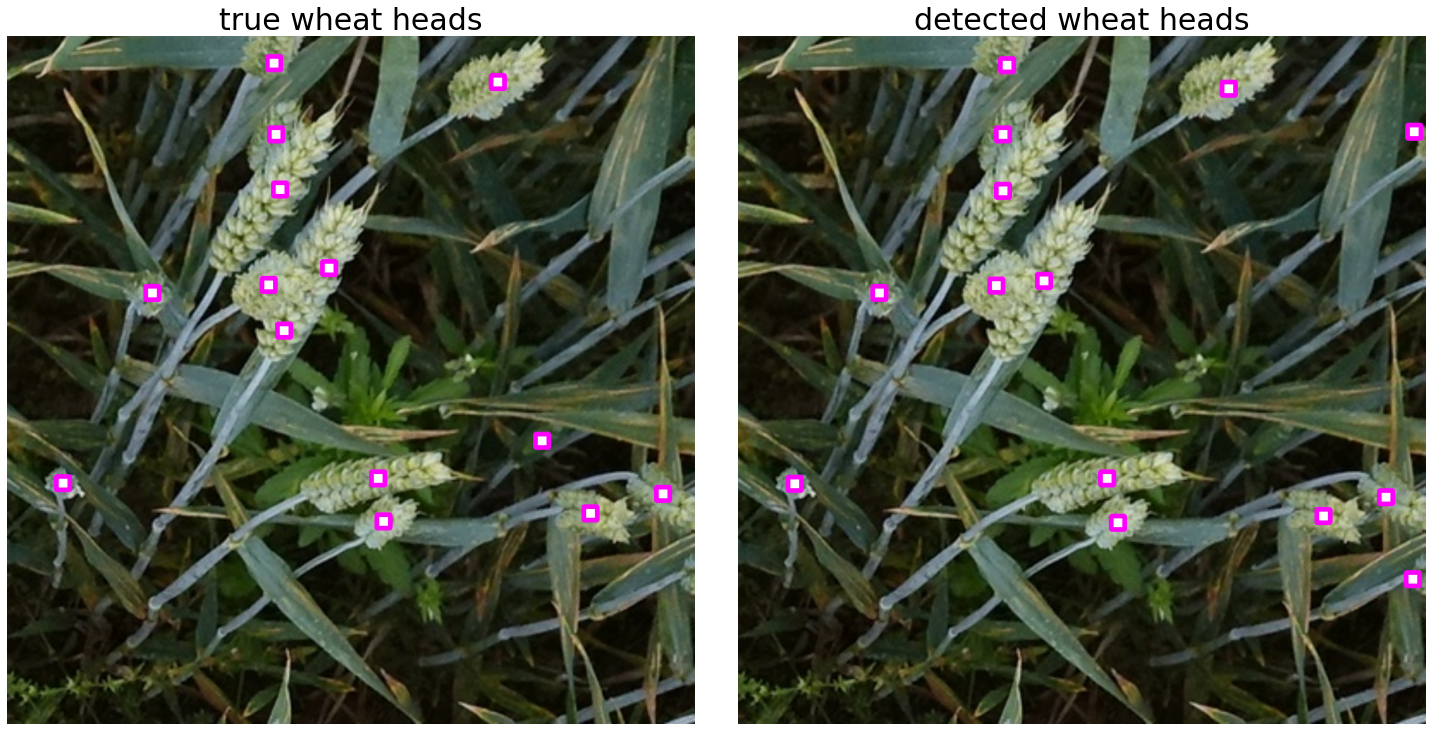

In [45]:
chosen_image_id = 7
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

6


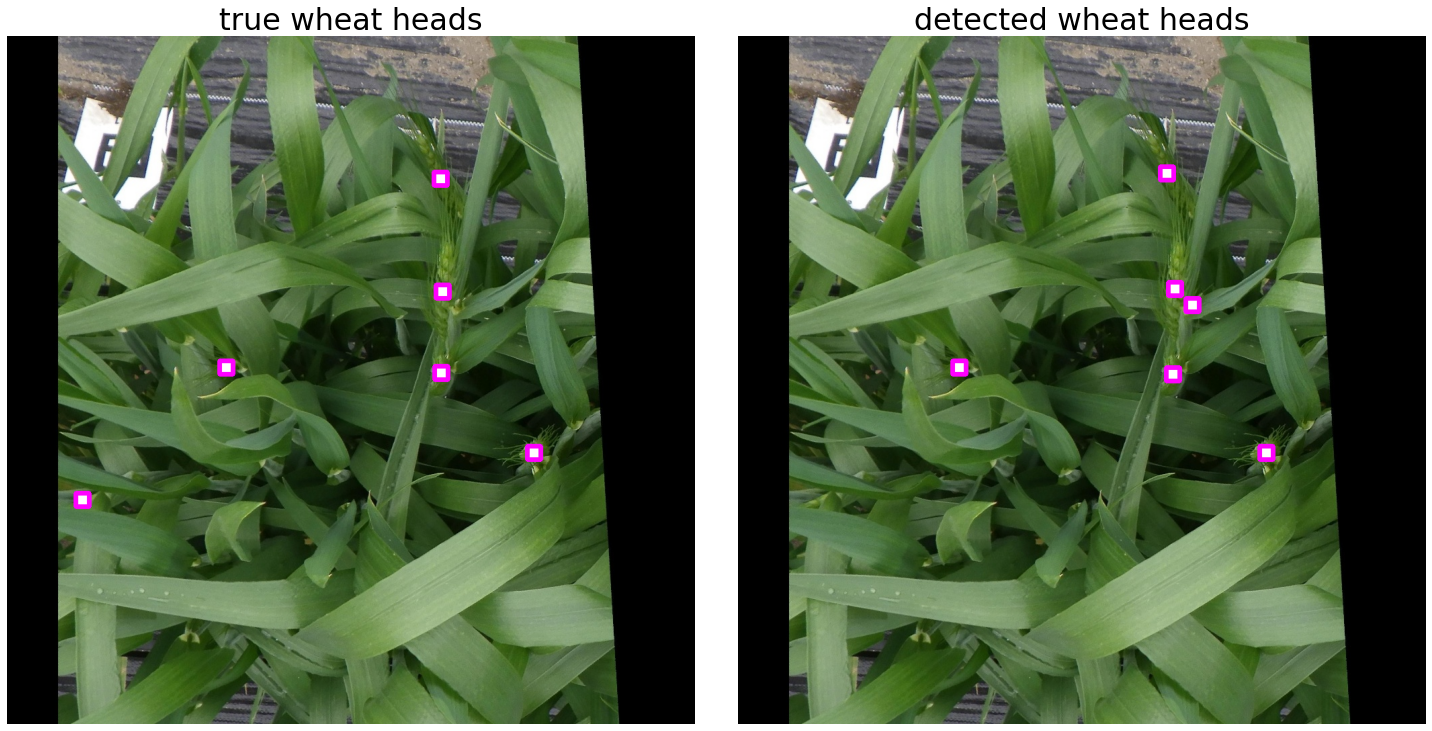

In [46]:
chosen_image_id = 2
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

12


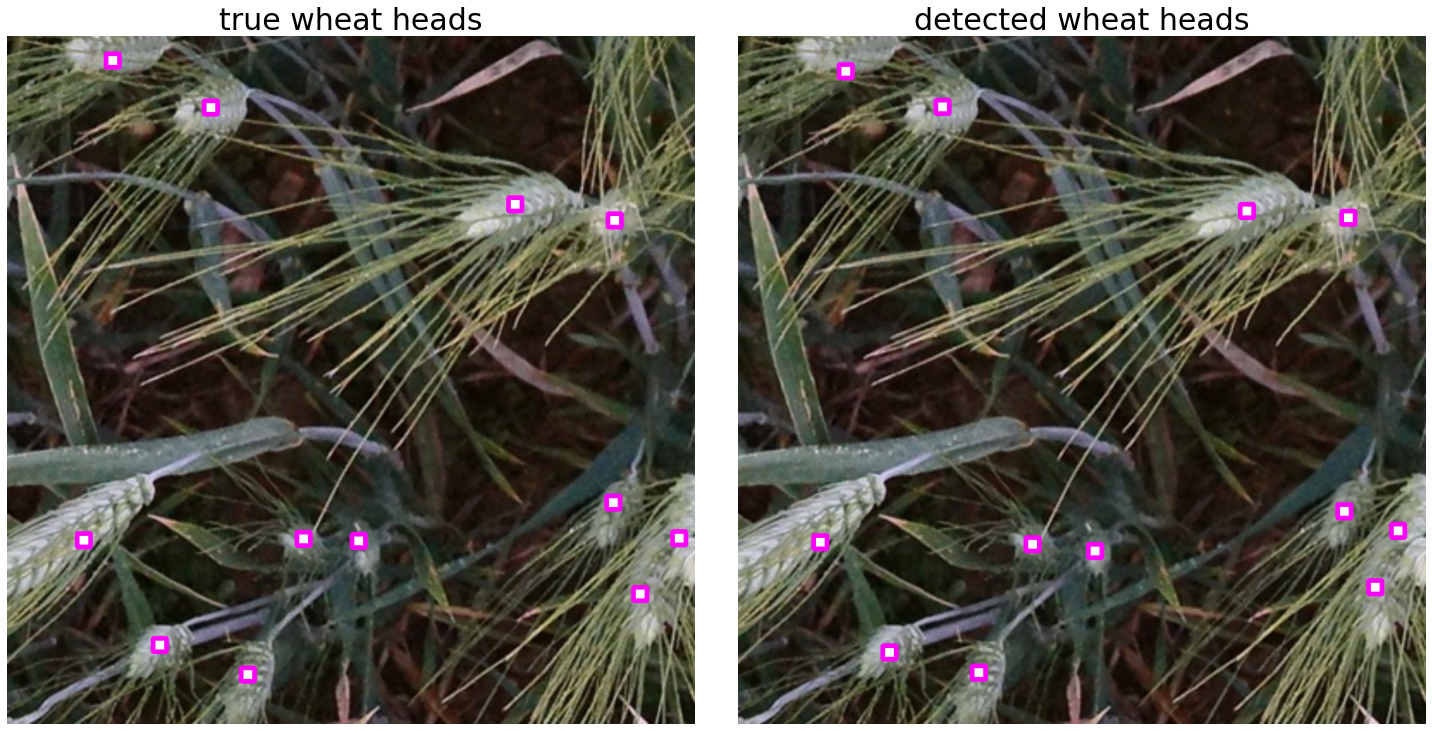

In [47]:
chosen_image_id = 5
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

## Display the three worst results

Each dot is the center of a bounding box.

1


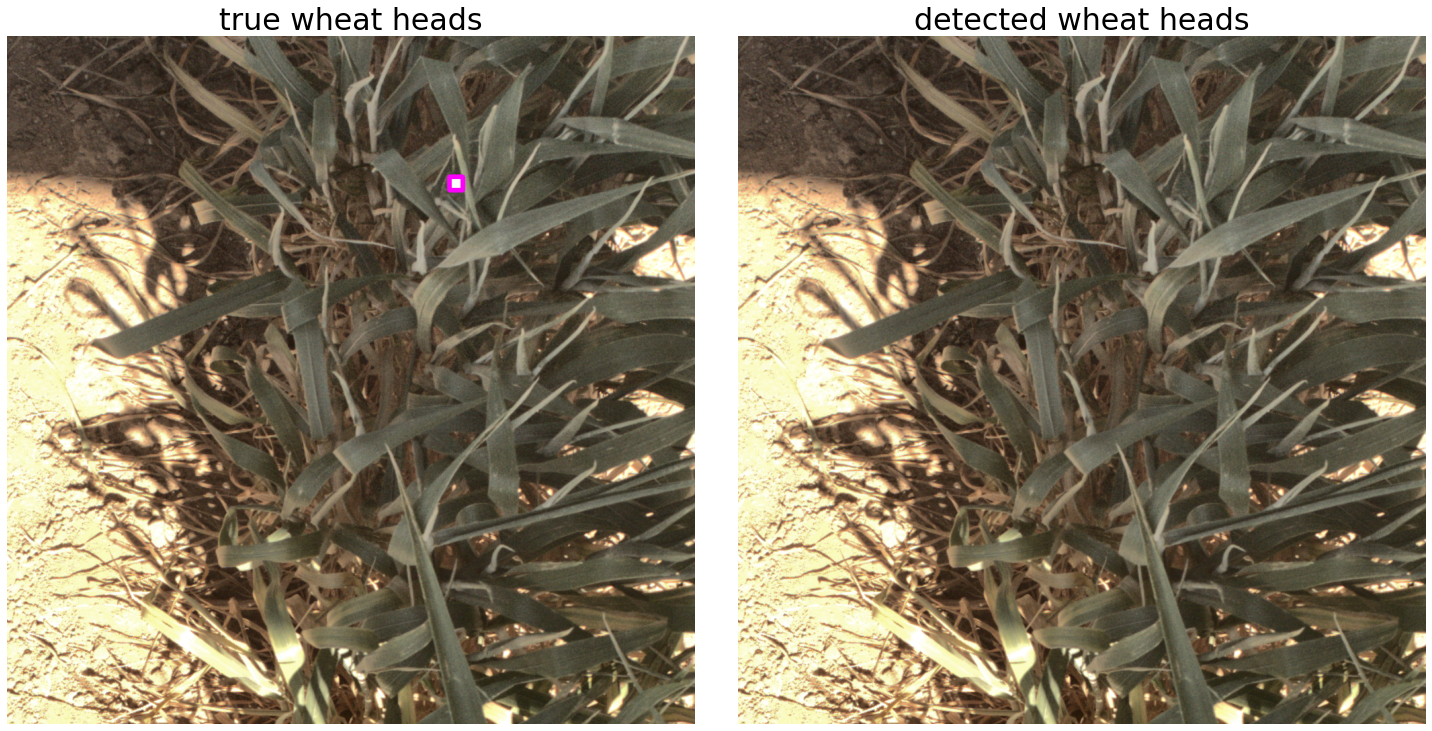

In [48]:
chosen_image_id = 910
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

1


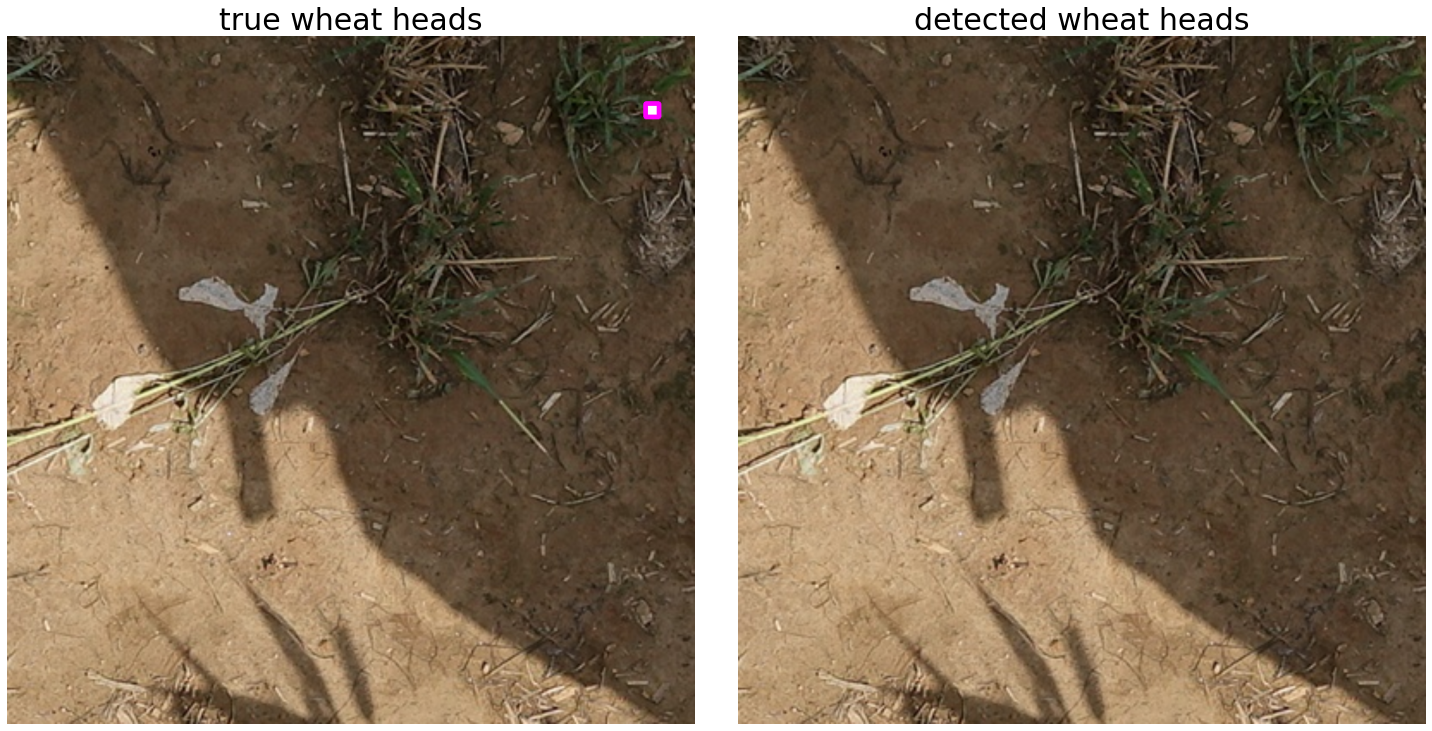

In [49]:
chosen_image_id = 911
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

3


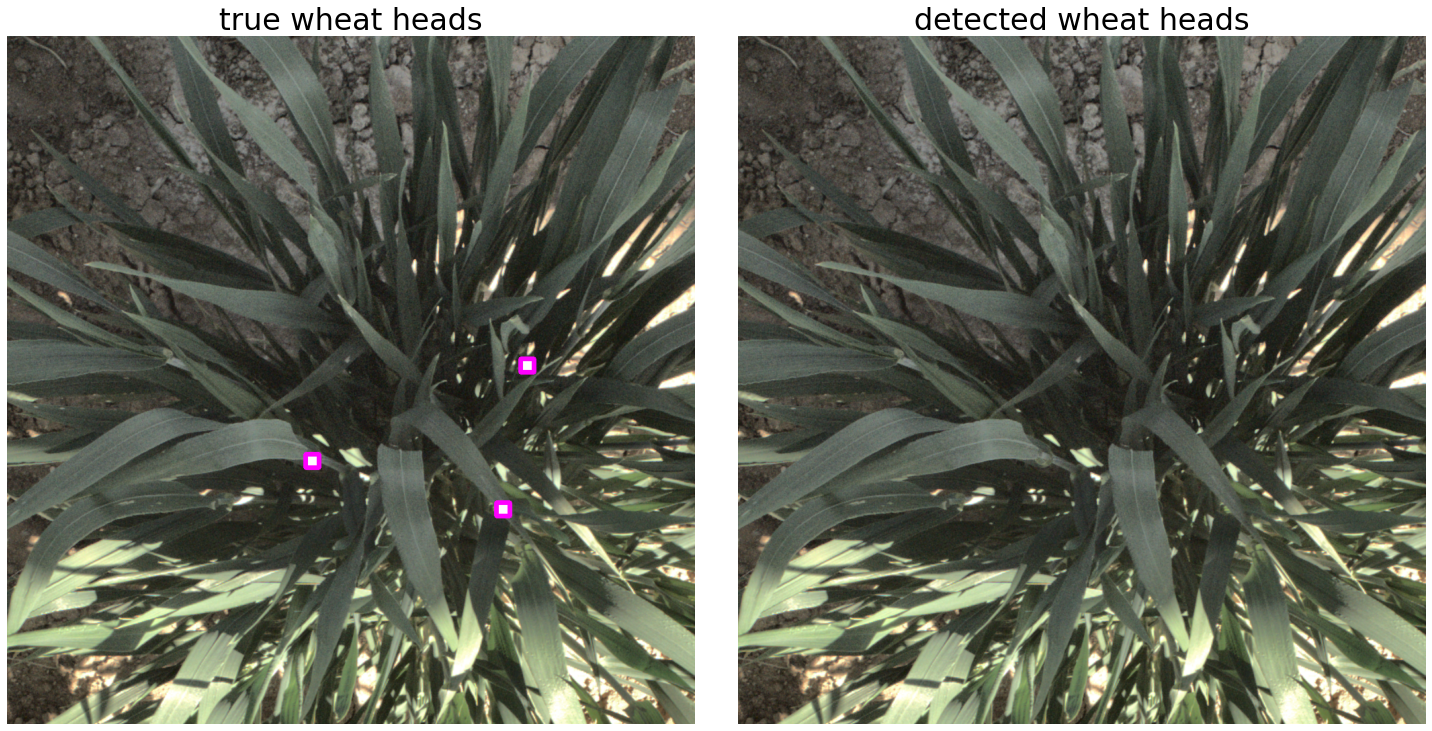

In [50]:
chosen_image_id = 912
image_id = df_sorted.loc[chosen_image_id, 'image_id']

show_true_and_pred_images(image_id)

## Save df_sorted

In [51]:
path = 'df_sorted.csv'
df_sorted.to_csv(path, index=False)

## Delete images to prevent notebook commit errors

In [52]:
# change the working directory to yolov5

os.chdir(f'{root}/yolov5')

!pwd

/kaggle/working/yolov5


In [53]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('base_dir') == True:
    shutil.rmtree('base_dir')

In [54]:
# change the working directory

os.chdir(root)

!pwd

/kaggle/working


In [55]:
!pip  freeze > requirements.txt

In [56]:
!ls

__notebook__.ipynb  df_domains.csv  requirements.txt  yolov5
df_dev.csv	    df_sorted.csv   yolo_images_dir
